<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Toronto</font></h1>
<h1 align=center><font size = 3>Yange Bian</font></h1>

## Introduction

This peer-reviewed assignment consists of three major goals. First, we need to apply basic web scraping skills to create and clean dataframe about toronto neighborhoods information from wikipedia. Second, we need to apply data analysis skills on multiple dataframes to extract, merge or group useful information. As a unsupervised machine learning algorithm, k means clustering model is used to fit the data. Most importantly, folium map, geopy and foursquare API are the essential tools to gather the accurate geographical data points, locate the center of toronto and visualize the neighborhood geographical information and the finalized, clustered dataframe onto the local map.

**Please note that the different required parts for submission will be clearly labeled and highlighted.**

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in Toronto from the boroughs ended with 'Toronto'</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

## 1. Download and Explore Dataset
In this part, all the libraries and tools are downloaded and loaded. Web page scraping is applied to download the wikipedia neighborhood information and the local geospatial data is also obtained. Based on the submission requirement, the wikipedia data is modified and sorted. The two main data sources are merged and showcased as panda dataframe.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: //anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |   py37hc8dfbb8_1         3.0 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-p

In [23]:
!conda install -c conda-forge wikipedia --yes

Solving environment: done

## Package Plan ##

  environment location: //anaconda3

  added / updated specs:
    - wikipedia


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wikipedia-1.4.0            |             py_2          13 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          13 KB

The following NEW packages will be INSTALLED:

  wikipedia          conda-forge/noarch::wikipedia-1.4.0-py_2



wikipedia-1.4.0      | 13 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [279]:
#find and extract the webpage of neighborhoods from wikipedia
import wikipedia as wp
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df=pd.read_html(html, header=0)[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Convert specific columns to string types

In [280]:
df['Borough']=df['Borough'].astype(str)
df['Postal Code']=df['Postal Code'].astype(str)
df['Neighborhood']=df['Neighborhood'].astype(str)


# Part 1 Submission

In [281]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
indexes_to_drop = []

for i in df.index:
    if df['Borough'][i]=='Not assigned':
        indexes_to_drop.append(i)

df.drop(df.index[indexes_to_drop], inplace=True)
df.head()
df.reset_index(drop=True, inplace=True)

#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
for j in df.index:
    if df['Neighborhood'][j]=='Not assigned':
        df['Neighborhood'][j]=df['Borough'][j]


In [282]:
df.reset_index(drop=True,inplace=True)
df.head(12)


,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [284]:
print('The number of rows in the dataframe is', df.shape[0])


The number of rows in the dataframe is 103


#### Gather Toronto geospatial data

In [285]:
import io
import requests
url="http://cocl.us/Geospatial_data"
lat_long=requests.get(url).text
lat_long_df=pd.read_csv(io.StringIO(lat_long))
lat_long_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


# Part 2 Submission
#### Merge geospatial data with neighborhood information by postal code

In [286]:
tr_df=pd.merge(df,lat_long_df, on="Postal Code")
tr_df.head(12)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [287]:
print('The dataframe has {} neighborhoods and {} boroughs.'.format(tr_df.shape[0],len(tr_df['Borough'].unique())))

The dataframe has 103 neighborhoods and 10 boroughs.


In [288]:
print('The 10 boroughs are namely', tr_df['Borough'].unique(), '.')

The 10 boroughs are namely ['North York' 'Downtown Toronto' 'Etobicoke' 'Scarborough' 'East York'
 'York' 'East Toronto' 'West Toronto' 'Central Toronto' 'Mississauga'] .


## 2. Explore Neighborhoods in Toronto from the boroughs ended with 'Toronto'
### Create a new dataframe with only those boroughs!

In [289]:
toronto_df=tr_df[tr_df['Borough']=="Central Toronto"]
toronto_df=tr_df[tr_df['Borough']=="Downtown Toronto"].append(toronto_df)
toronto_df=tr_df[tr_df['Borough']=="East Toronto"].append(toronto_df)
toronto_df=tr_df[tr_df['Borough']=="West Toronto"].append(toronto_df)
toronto_df.reset_index(drop=True, inplace=True)
print('The data with boroughs that contain the word "Toronto" has', toronto_df.shape[0], 'rows .')
toronto_df.head(50)

The data with boroughs that contain the word "Toronto" has 39 rows .


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259
1,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750
2,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191
3,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763
4,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325
5,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450
6,M4E,East Toronto,The Beaches,43.676357,-79.293031
7,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
8,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
9,M4M,East Toronto,Studio District,43.659526,-79.340923


### Get the geographical coordinate of the center of Toronto

In [290]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### create map of Toronto using ONLY latitude and longitude values from the boroughs ended with 'Toronto'.

In [291]:
# create map of Toronto using ONLY latitude and longitude values from the boroughs ended with 'Toronto'.
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Apply Foursquare API to obtain venue data information

In [292]:
CLIENT_ID = 'AHWOKU1BZMJEJZKZKOHR1QJVOHIKPECDSKVRRX0CWM5JBG1F' # my Foursquare ID
CLIENT_SECRET = 'LDEANZTVP1Y52QHELJHZXSQTUH2SAF3QNMHWCPL2HUR5TZE5' # my Foursquare Secret
VERSION = '20200711' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AHWOKU1BZMJEJZKZKOHR1QJVOHIKPECDSKVRRX0CWM5JBG1F
CLIENT_SECRET:LDEANZTVP1Y52QHELJHZXSQTUH2SAF3QNMHWCPL2HUR5TZE5


### Explore first neighborhood in the dataframe

In [293]:
#first neighborhood(s) in the dataframe.
toronto_df.loc[0, 'Neighborhood']

'Dufferin, Dovercourt Village'

In [294]:
neighborhood_latitude = toronto_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Dufferin, Dovercourt Village are 43.66900510000001, -79.4422593.


In [295]:
#Now, let's get the top 100 venues that are in Dufferin, Dovercourt Village within a radius of 500 meters.
radius=500
LIMIT=100

url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&radius={}&limit={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, radius, LIMIT, VERSION)

url

'https://api.foursquare.com/v2/venues/explore?client_id=AHWOKU1BZMJEJZKZKOHR1QJVOHIKPECDSKVRRX0CWM5JBG1F&client_secret=LDEANZTVP1Y52QHELJHZXSQTUH2SAF3QNMHWCPL2HUR5TZE5&ll=43.66900510000001,-79.4422593&radius=500&limit=100&v=20200711'

In [296]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f0c5a8dda803b65d214f3cf'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Davenport',
  'headerFullLocation': 'Davenport, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 14,
  'suggestedBounds': {'ne': {'lat': 43.67350510450001,
    'lng': -79.43604977526607},
   'sw': {'lat': 43.664505095500004, 'lng': -79.44846882473394}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5753753b498eeb535c53aed5',
       'name': 'The Greater Good Bar',
       'location': {'address': '229 Geary St',
        'crossStreet': 'at Dufferin St',
        'lat': 43.669409,
        'lng': -79.439267,
        'labeledLatLngs': [{'label': 'disp

In [297]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [298]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,The Greater Good Bar,Bar,43.669409,-79.439267
1,Parallel,Middle Eastern Restaurant,43.669516,-79.438728
2,FreshCo,Grocery Store,43.667918,-79.440754
3,Blood Brothers Brewing,Brewery,43.669944,-79.436533
4,Happy Bakery & Pastries,Bakery,43.667050,-79.441791


In [299]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

14 venues were returned by Foursquare.


## 3. Analyze Each Neighborhood

In [300]:
#Same process to ALL neighborhoods in the boroughs that contain "Toronto".
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [301]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The Junction South
Parkdale, Roncesvalles
Runnymede, Swansea
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter Processing Plant Toronto
Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, F

In [303]:
print(toronto_venues.shape)
toronto_venues.head()

(1620, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Dufferin, Dovercourt Village",43.669005,-79.442259,The Greater Good Bar,43.669409,-79.439267,Bar
1,"Dufferin, Dovercourt Village",43.669005,-79.442259,Parallel,43.669516,-79.438728,Middle Eastern Restaurant
2,"Dufferin, Dovercourt Village",43.669005,-79.442259,FreshCo,43.667918,-79.440754,Grocery Store
3,"Dufferin, Dovercourt Village",43.669005,-79.442259,Blood Brothers Brewing,43.669944,-79.436533,Brewery
4,"Dufferin, Dovercourt Village",43.669005,-79.442259,Happy Bakery & Pastries,43.667050,-79.441791,Bakery


#### Group the venue data by neighborhoods and explore the count (especially for the venue category)

In [304]:
toronto_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,68,68,68,68,68,68
Christie,17,17,17,17,17,17
Church and Wellesley,70,70,70,70,70,70
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,37,37,37,37,37,37


In [305]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 229 uniques categories.


In [306]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
toronto_onehot.set_index('Neighborhood', inplace=True)
toronto_onehot.reset_index(inplace=True)
toronto_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Dufferin, Dovercourt Village",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Dufferin, Dovercourt Village",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [307]:
toronto_onehot.shape

(1620, 229)

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [308]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.0000,0.017544,0.000000,0.017544,0.035088,0.000000,0.000000,0.00,0.017544,0.017544,0.000000,0.035088,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.087719,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.017544,0.000000,0.017544,0.000000,0.00,0.000000,0.000,0.017544,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.0

In [309]:
toronto_grouped.shape

(39, 229)

#### Let's print each neighborhood along with the top 5 most common venues

In [310]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2  Seafood Restaurant  0.04
3         Cheese Shop  0.04
4      Farmers Market  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1          Bakery  0.09
2     Coffee Shop  0.09
3  Breakfast Spot  0.09
4   Grocery Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0           Pizza Place  0.06
1      Recording Studio  0.06
2  Fast Food Restaurant  0.06
3            Smoke Shop  0.06
4         Burrito Place  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.18
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3           Airport  0.06
4     Boat or Ferry  0.06


----Central Bay Street----
                venue  freq
0       

### Let's put that into a pandas dataframe
#### First, let's write a function to sort the venues in descending order.

In [311]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [312]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Café,Cheese Shop,Farmers Market,Seafood Restaurant,Bakery,Restaurant,Beer Bar,Lounge
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Bakery,Burrito Place,Restaurant,Stadium,Italian Restaurant,Intersection,Bar
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Pizza Place,Recording Studio,Fast Food Restaurant,Skate Park,Farmers Market,Auto Workshop,Burrito Place,Restaurant,Garden
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Airport,Sculpture Garden,Plane,Coffee Shop,Harbor / Marina,Rental Car Location,Boat or Ferry
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Salad Place,Bubble Tea Shop,Burger Joint,Bar,Thai Restaurant,Japanese Restaurant


## 4. Cluster Neighborhoods
# Part 3 Submission

In [313]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
toronto_grouped_clustering=toronto_grouped.drop('Neighborhood',1)


#### Create a plot (number of clusters vs squared errors) to identify the elbow (the BEST number of clusters to fit the data)

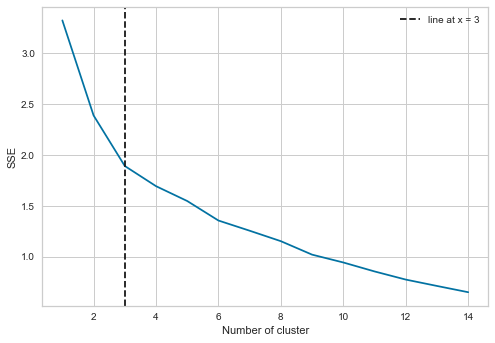

In [314]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(toronto_grouped_clustering)
    toronto_grouped_clustering["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.axvline(x=3, color='k', linestyle='--',label='line at x = 3')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend()
plt.show()

#### Use 3 clusters to fit the data

In [315]:
kclusters=3
kmeans=KMeans(n_clusters=kclusters,random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10]



array([0, 2, 2, 0, 0, 1, 0, 0, 0, 2], dtype=int32)

#### Create a new dataframe to add the cluster labels and merge the toronto geospatial data with the top 10 venue data by neighborhoods

In [316]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_df

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,1,Pharmacy,Bakery,Pet Store,Music Venue,Middle Eastern Restaurant,Café,Brewery,Bar,Supermarket,Bank
1,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,2,Bar,Café,Coffee Shop,Vietnamese Restaurant,Asian Restaurant,Restaurant,Men's Store,Japanese Restaurant,Juice Bar,Korean Restaurant
2,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,2,Café,Breakfast Spot,Coffee Shop,Bakery,Burrito Place,Restaurant,Stadium,Italian Restaurant,Intersection,Bar
3,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,2,Mexican Restaurant,Café,Thai Restaurant,Fast Food Restaurant,Arts & Crafts Store,Bar,Bakery,Speakeasy,Diner,Cajun / Creole Restaurant
4,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,2,Gift Shop,Breakfast Spot,Dessert Shop,Bookstore,Restaurant,Movie Theater,Bar,Cuban Restaurant,Italian Restaurant,Dog Run


#### Visualize clustering results

In [317]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters
# Part 3 Submission

### Cluster 1

In [318]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"Runnymede, Swansea",Coffee Shop,Café,Sushi Restaurant,Pizza Place,Pub,Italian Restaurant,Bookstore,Bar,Fish & Chips Shop,Indie Movie Theater
7,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Restaurant,Bubble Tea Shop,Bakery,Pub,Pizza Place
9,Studio District,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Comfort Food Restaurant,Seafood Restaurant,Sandwich Place,Cheese Shop
11,"Regent Park, Harbourfront",Coffee Shop,Bakery,Park,Breakfast Spot,Café,Pub,Theater,Yoga Studio,Mexican Restaurant,Shoe Store
12,"Queen's Park, Ontario Provincial Government",Coffee Shop,Diner,College Cafeteria,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,General Entertainment,Park
13,"Garden District, Ryerson",Clothing Store,Coffee Shop,Italian Restaurant,Japanese Restaurant,Café,Hotel,Bubble Tea Shop,Cosmetics Shop,Ramen Restaurant,Bookstore
14,St. James Town,Coffee Shop,Café,Restaurant,Clothing Store,Cosmetics Shop,American Restaurant,Cocktail Bar,Department Store,Seafood Restaurant,Breakfast Spot
15,Berczy Park,Coffee Shop,Cocktail Bar,Café,Cheese Shop,Farmers Market,Seafood Restaurant,Bakery,Restaurant,Beer Bar,Lounge
16,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Salad Place,Bubble Tea Shop,Burger Joint,Bar,Thai Restaurant,Japanese Restaurant
18,"Richmond, Adelaide, King",Coffee Shop,Café,Restaurant,Hotel,Deli / Bodega,Gym,Thai Restaurant,Concert Hall,Salad Place,Pizza Place


### Cluster 2

In [319]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Dufferin, Dovercourt Village",Pharmacy,Bakery,Pet Store,Music Venue,Middle Eastern Restaurant,Café,Brewery,Bar,Supermarket,Bank
6,The Beaches,Trail,Health Food Store,Pub,Yoga Studio,Dance Studio,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run
17,Christie,Grocery Store,Café,Park,Candy Store,Restaurant,Baby Store,Coffee Shop,Italian Restaurant,Nightclub,Athletics & Sports
25,Rosedale,Park,Playground,Trail,Yoga Studio,Cupcake Shop,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
33,"Forest Hill North & West, Forest Hill Road Park",Park,Trail,Jewelry Store,Sushi Restaurant,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant
37,"Moore Park, Summerhill East",Park,Trail,Yoga Studio,Dance Studio,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


### Cluster 3

In [320]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Little Portugal, Trinity",Bar,Café,Coffee Shop,Vietnamese Restaurant,Asian Restaurant,Restaurant,Men's Store,Japanese Restaurant,Juice Bar,Korean Restaurant
2,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Bakery,Burrito Place,Restaurant,Stadium,Italian Restaurant,Intersection,Bar
3,"High Park, The Junction South",Mexican Restaurant,Café,Thai Restaurant,Fast Food Restaurant,Arts & Crafts Store,Bar,Bakery,Speakeasy,Diner,Cajun / Creole Restaurant
4,"Parkdale, Roncesvalles",Gift Shop,Breakfast Spot,Dessert Shop,Bookstore,Restaurant,Movie Theater,Bar,Cuban Restaurant,Italian Restaurant,Dog Run
8,"India Bazaar, The Beaches West",Park,Sandwich Place,Brewery,Steakhouse,Fish & Chips Shop,Ice Cream Shop,Sushi Restaurant,Liquor Store,Restaurant,Italian Restaurant
10,"Business reply mail Processing Centre, South C...",Light Rail Station,Pizza Place,Recording Studio,Fast Food Restaurant,Skate Park,Farmers Market,Auto Workshop,Burrito Place,Restaurant,Garden
22,"University of Toronto, Harbord",Café,Bookstore,Bar,Japanese Restaurant,Sandwich Place,Restaurant,Bakery,Pub,Dessert Shop,Chinese Restaurant
23,"Kensington Market, Chinatown, Grange Park",Café,Coffee Shop,Bar,Mexican Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Dessert Shop,Bakery,Grocery Store,Pizza Place
31,Roselawn,Music Venue,Garden,Cupcake Shop,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
32,Davisville North,Department Store,Park,Breakfast Spot,Gym / Fitness Center,Sandwich Place,Hotel,Food & Drink Shop,Discount Store,Dessert Shop,Diner


### Closing Remarks on clusters
In cluster 1, the neighborhoods have coffee shop (or cafe) as the top common venue. In cluster 2, the neighborhoods have public facilities such as park, airport, or trail as the top common venue. In cluster 3, the neighborhoods have many mixed common venues including public facilities, shops, schools and restaurants.